# Neural Networks

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Set random seeds
np.random.seed(0)
torch.manual_seed(0)
os.environ['PYTHONHASHSEED'] = str(0)

In [127]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

class FullyConnected(nn.Module):
         
    def __init__(self, in_features, num_classes):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(in_features, 2 * in_features, bias=True),
            nn.ReLU(),
            nn.Linear(2 * in_features, in_features, bias=True),
            nn.ReLU(),
            nn.Linear(in_features, num_classes)
        )
        self.model.apply(init_weights)
        
    def forward(self, X):
        return self.model(X)

In [128]:
class TabularDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [147]:
# Define hyperparam
hyperparam = {
    "batch_size": 64,
    "lr": 1e-5,
    "weight_decay": 1e-3
}

In [148]:
# Prepare data

df = np.array(pd.read_csv("fetal_health.csv"), dtype=np.float32)
np.random.shuffle(df)
X = np.array(df[:, :-1])
y = np.array(df[:, -1], dtype=np.int64) - 1 # We subtract 1 to make classes 0,1,2 instead of 1,2,3
num_data = len(y)
num_train = int(np.floor(num_data * 0.6))
num_val = int(np.floor(num_data * 0.2))

train_X = X[:num_train]
train_y = y[:num_train]

val_X = X[num_train:num_train + num_val]
val_y = y[num_train:num_train + num_val]

test_X = X[num_train + num_val:]
test_y = y[num_train + num_val:]

train_dataset = TabularDataset(train_X, train_y)
val_dataset = TabularDataset(val_X, val_y)
test_dataset = TabularDataset(test_X, test_y)

train_loader = DataLoader(train_dataset, batch_size=hyperparam["batch_size"], shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=hyperparam["batch_size"], shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=hyperparam["batch_size"], shuffle=True, drop_last=True)

In [149]:
model = FullyConnected(train_X.shape[1], len(np.unique(y)))

In [150]:
loss_criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), hyperparam["lr"], weight_decay=hyperparam["weight_decay"])
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.99) 
num_epochs = 300

In [151]:
def predict(model, dataloader):
    num_correct = 0
    num_total = 0
    with torch.no_grad():
        for i, data in enumerate(train_loader):
            # Unpack data
            batch_X, batch_y = data

            # Perform forward pass
            pred = model(batch_X)
            
            num_correct += (torch.argmax(out, dim=1) == batch_y).int().sum()
            num_total += len(batch_y)
    return num_correct / num_total
    

In [152]:
# Training loop

losses = []
train_accuracies = []
val_accuracies = []
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader):
        # Unpack data
        batch_X, batch_y = data
        
        # Zero previous grad
        optimizer.zero_grad()
        
        # Perform forward pass
        out = model(batch_X)
        loss = loss_criterion(out, batch_y)
        
        # Perform backward pass
        loss.backward()
        
        # Update learning rate
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        if i % 10 == 9:    # print every 10 mini-batches
            average_loss = running_loss / 10
            losses.append(average_loss)
            running_loss = 0.0
            
            with torch.no_grad():
                acc = torch.mean((torch.argmax(out, dim=1) == batch_y).float())
                train_accuracies.append(acc)
            print(f'[Epoch {epoch + 1}, Iteration {i + 1}] loss: {average_loss} train_accuracy: {acc}')
    with torch.no_grad():
        acc = predict(model, val_loader)
        val_accuracies.append(acc)
        print(f'[Epoch {epoch + 1}] val_accuracy: {acc}')

[Epoch 1, Iteration 10] loss: 75.1158233642578 train_accuracy: 0.046875
[Epoch 1] val_accuracy: 0.14144736528396606
[Epoch 2, Iteration 10] loss: 73.81652374267578 train_accuracy: 0.046875
[Epoch 2] val_accuracy: 0.13980263471603394
[Epoch 3, Iteration 10] loss: 70.69927825927735 train_accuracy: 0.171875
[Epoch 3] val_accuracy: 0.1381578892469406
[Epoch 4, Iteration 10] loss: 69.00291595458984 train_accuracy: 0.171875
[Epoch 4] val_accuracy: 0.13322368264198303
[Epoch 5, Iteration 10] loss: 68.694380569458 train_accuracy: 0.078125
[Epoch 5] val_accuracy: 0.1381578892469406
[Epoch 6, Iteration 10] loss: 67.7504379272461 train_accuracy: 0.140625
[Epoch 6] val_accuracy: 0.13569079339504242
[Epoch 7, Iteration 10] loss: 66.3564453125 train_accuracy: 0.09375
[Epoch 7] val_accuracy: 0.13651315867900848
[Epoch 8, Iteration 10] loss: 63.08354530334473 train_accuracy: 0.15625
[Epoch 8] val_accuracy: 0.13898026943206787
[Epoch 9, Iteration 10] loss: 62.115875244140625 train_accuracy: 0.203125
[E

[Epoch 78] val_accuracy: 0.5518091917037964
[Epoch 79, Iteration 10] loss: 4.918622994422913 train_accuracy: 0.671875
[Epoch 79] val_accuracy: 0.6118420958518982
[Epoch 80, Iteration 10] loss: 5.197802233695984 train_accuracy: 0.71875
[Epoch 80] val_accuracy: 0.5797697305679321
[Epoch 81, Iteration 10] loss: 4.128985953330994 train_accuracy: 0.671875
[Epoch 81] val_accuracy: 0.6241776347160339
[Epoch 82, Iteration 10] loss: 4.4620778322219845 train_accuracy: 0.796875
[Epoch 82] val_accuracy: 0.5370065569877625
[Epoch 83, Iteration 10] loss: 4.656150639057159 train_accuracy: 0.625
[Epoch 83] val_accuracy: 0.5838815569877625
[Epoch 84, Iteration 10] loss: 5.330311059951782 train_accuracy: 0.703125
[Epoch 84] val_accuracy: 0.6463815569877625
[Epoch 85, Iteration 10] loss: 4.920447516441345 train_accuracy: 0.75
[Epoch 85] val_accuracy: 0.5608552694320679
[Epoch 86, Iteration 10] loss: 4.92726743221283 train_accuracy: 0.796875
[Epoch 86] val_accuracy: 0.6439144611358643
[Epoch 87, Iteration

[Epoch 148, Iteration 10] loss: 1.7351797223091125 train_accuracy: 0.84375
[Epoch 148] val_accuracy: 0.6192434430122375
[Epoch 149, Iteration 10] loss: 1.9172531127929688 train_accuracy: 0.734375
[Epoch 149] val_accuracy: 0.6768091917037964
[Epoch 150, Iteration 10] loss: 1.9074859201908112 train_accuracy: 0.828125
[Epoch 150] val_accuracy: 0.5822368264198303
[Epoch 151, Iteration 10] loss: 1.6761411607265473 train_accuracy: 0.734375
[Epoch 151] val_accuracy: 0.7154605388641357
[Epoch 152, Iteration 10] loss: 1.9332677364349364 train_accuracy: 0.671875
[Epoch 152] val_accuracy: 0.5978618264198303
[Epoch 153, Iteration 10] loss: 1.5519531548023224 train_accuracy: 0.765625
[Epoch 153] val_accuracy: 0.6159539222717285
[Epoch 154, Iteration 10] loss: 1.7899095296859742 train_accuracy: 0.65625
[Epoch 154] val_accuracy: 0.5789473652839661
[Epoch 155, Iteration 10] loss: 1.6862989723682404 train_accuracy: 0.765625
[Epoch 155] val_accuracy: 0.6463815569877625
[Epoch 156, Iteration 10] loss: 1.

[Epoch 219] val_accuracy: 0.6348684430122375
[Epoch 220, Iteration 10] loss: 1.5148185729980468 train_accuracy: 0.703125
[Epoch 220] val_accuracy: 0.625
[Epoch 221, Iteration 10] loss: 1.225725346803665 train_accuracy: 0.734375
[Epoch 221] val_accuracy: 0.6192434430122375
[Epoch 222, Iteration 10] loss: 1.3362334489822387 train_accuracy: 0.8125
[Epoch 222] val_accuracy: 0.6768091917037964
[Epoch 223, Iteration 10] loss: 1.2437095165252685 train_accuracy: 0.765625
[Epoch 223] val_accuracy: 0.6184210777282715
[Epoch 224, Iteration 10] loss: 1.33128319978714 train_accuracy: 0.8125
[Epoch 224] val_accuracy: 0.6291118264198303
[Epoch 225, Iteration 10] loss: 1.205887758731842 train_accuracy: 0.78125
[Epoch 225] val_accuracy: 0.6069079041481018
[Epoch 226, Iteration 10] loss: 1.3264709055423736 train_accuracy: 0.75
[Epoch 226] val_accuracy: 0.5699012875556946
[Epoch 227, Iteration 10] loss: 1.277401077747345 train_accuracy: 0.734375
[Epoch 227] val_accuracy: 0.640625
[Epoch 228, Iteration 10

[Epoch 292, Iteration 10] loss: 1.0888158857822419 train_accuracy: 0.78125
[Epoch 292] val_accuracy: 0.6258223652839661
[Epoch 293, Iteration 10] loss: 1.0474616229534148 train_accuracy: 0.859375
[Epoch 293] val_accuracy: 0.6521381735801697
[Epoch 294, Iteration 10] loss: 0.9551581263542175 train_accuracy: 0.828125
[Epoch 294] val_accuracy: 0.5855262875556946
[Epoch 295, Iteration 10] loss: 1.1668688237667084 train_accuracy: 0.734375
[Epoch 295] val_accuracy: 0.6570723652839661
[Epoch 296, Iteration 10] loss: 1.129935073852539 train_accuracy: 0.734375
[Epoch 296] val_accuracy: 0.6595394611358643
[Epoch 297, Iteration 10] loss: 1.0752359926700592 train_accuracy: 0.71875
[Epoch 297] val_accuracy: 0.6118420958518982
[Epoch 298, Iteration 10] loss: 1.0023059964179992 train_accuracy: 0.796875
[Epoch 298] val_accuracy: 0.6134868264198303
[Epoch 299, Iteration 10] loss: 1.0926725566387177 train_accuracy: 0.796875
[Epoch 299] val_accuracy: 0.5921052694320679
[Epoch 300, Iteration 10] loss: 1.0

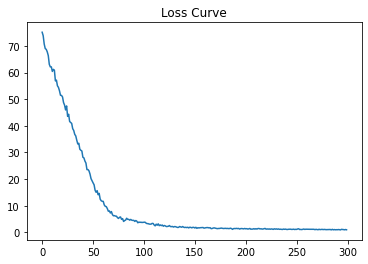

In [153]:
plt.plot(losses)
plt.title("Loss Curve")
plt.show()

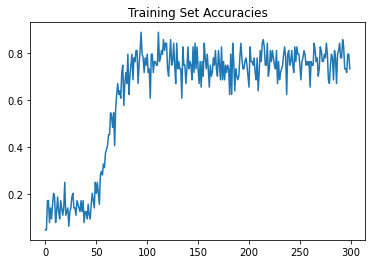

In [154]:
plt.plot(train_accuracies)
plt.title("Training Set Accuracies")
plt.show()

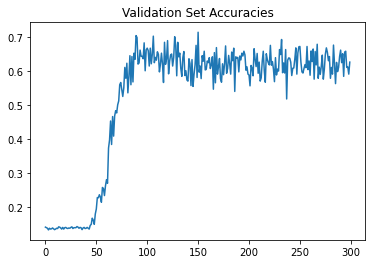

In [155]:
plt.plot(val_accuracies)
plt.title("Validation Set Accuracies")
plt.show()